In [66]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import datetime

In [67]:
# import to ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [68]:
from sklearn.preprocessing import MinMaxScaler

In [69]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

##### 1.Load the stock data from Yahoo Finance

###### Dowload Stock Data

In [70]:
# Choose a stock ticker symbol, e.g., 'AAPL' for Apple Inc.
ticker = 'AAPL'

###### # Download historical data from Yahoo Finance

In [71]:
data = yf.download(ticker, start='2020-01-01', end=datetime.datetime.today().strftime('%Y-%m-%d'))
# Focus on 'Close' prices for simplicity
data = data[['Close']]

[*********************100%***********************]  1 of 1 completed


##### 2.Preprocess and Scale the Data

In [72]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

#### Step 3: Prepare Training Data

In [73]:
# Define training data length as 80% of the total data
training_data_len = int(np.ceil(len(scaled_data) * 0.8))

# Split the scaled data into the training set
train_data = scaled_data[0:int(training_data_len), :]

In [74]:
x_train=[]
y_train=[]

In [75]:
for i in range (60,len(train_data)):
    x_train.append(train_data[i-60:i,0])#for past 60 days
    y_train.append(train_data[i,0])#for the  nextdays close price

In [76]:
# Convert lists to numpy arrays for model training
x_train, y_train = np.array(x_train), np.array(y_train)

In [77]:
#reshape x_train to the format [samples, time steps, features] required for LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

##### 4.Build LSTM Model

In [78]:
model=Sequential()

In [79]:
# First LSTM layer with 50 units and return sequences
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting

In [80]:
# Second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting


In [81]:
# Dense layer with 25 units
model.add(Dense(units=25))
model.add(Dense(units=1))

In [82]:
# Compile the model using Adam optimizer and mean squared error as the loss function
model.compile(optimizer='adam', loss='mean_squared_error')

##### 5.Train the model with the training data.

In [83]:
model.fit(x_train,y_train,batch_size=1,epochs=1)

1110/1110 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - loss: 0.0040


##### 6.Prepare data for generating future predictions.

In [84]:
# Take the last 60 days from the dataset for generating future predictions
last_60_days = scaled_data[-60:]

In [85]:
# Reshape last_60_days to fit the model input shape (1 sample, 60 timesteps, 1 feature)
x_future = last_60_days.reshape((1, last_60_days.shape[0], 1))

##### 7.Generate 30-day Forecast

In [86]:
future_predictions = [] #for 30days
for _ in range(30):  # Change 30 to 60 to predict for 60 days
    # Predict the next day’s closing price based on the last 60 days
    pred = model.predict(x_future)
    future_predictions.append(pred[0, 0])  # Add prediction to the list

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━

In [87]:
# Update x_future with the new prediction by removing the first value and adding the new prediction
x_future = np.append(x_future[:, 1:, :], [[pred[0]]], axis=1)

##### Step 8: Transform Predictions Back to Original Scale

In [88]:
# Convert the scaled predictions back to the original scale using inverse_transform
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

##### 9.Visualize the Results

In [89]:
# Create a DataFrame to hold the 30-day forecast with dates
forecast_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30, freq='B')
forecast = pd.DataFrame(future_predictions, index=forecast_dates, columns=['Prediction'])

##### Plot historical data and future predictions for comparison


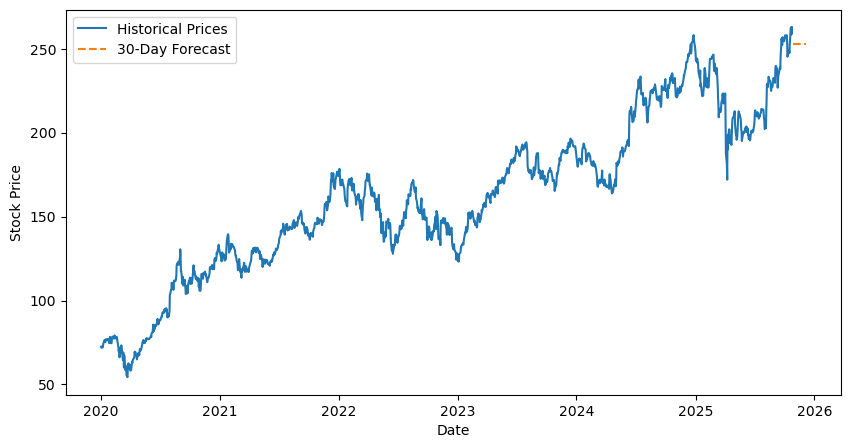

In [90]:
plt.figure(figsize=(10, 5))
plt.plot(data['Close'], label='Historical Prices')
plt.plot(forecast, label='30-Day Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

###### The Blue is the Last 60 days of data.

#### END OF CODE